In [2]:
import math
import numpy as np
from scipy.optimize import fsolve

In [3]:
from scipy.special import erfinv

Verify integration

In [56]:
def compute_int(y, sigma=1):
    return np.sqrt(np.pi/2) * sigma * (math.erf((y+3)/(sigma*np.sqrt(2))) - math.erf((y-3)/(sigma*np.sqrt(2))))
print(compute_int(-2.8))
x = np.linspace(-3, 3, 10000)
print(0.0006 * np.sum(np.exp(-np.square(x+2.8)/2)[:9999]))

1.4519887577232509
1.452137612552812


$Z_i \sim Ber(\theta)$\
$\beta_i \sim U(-a,a)$\
$Y_i|Z_i, \beta_i \sim N(z_i \circ \beta_i, \sigma^2)$

In [20]:
''' 
compute normalization constant
'''
def compute_c(y, theta, a, sigma):
    c = 2*a * (1-theta) * np.exp(-y**2 / (2 * sigma**2)) \
    + theta * np.sqrt(np.pi/2) * sigma * \
    (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-a)/(sigma*np.sqrt(2))))
    return c

In [25]:
''' 
compute the cumulative probablity of the marginal distribution of beta
'''
def cumulative_prob(t, y, norm_c, theta, a, sigma):
    assert t>=-a and t<=a
    prob = (1-theta) * np.exp(-y**2 / (2 * sigma**2)) * (t+a) / norm_c \
        + theta * np.sqrt(np.pi/2) * sigma * \
            (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / norm_c
    return prob

In [28]:
y = 2
theta = 0.05
a = 3
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)

0.876858004982628


In [29]:
cumulative_prob(-3, y, c, theta, a, sigma)

0.0

In [30]:
cumulative_prob(3, y, c, theta, a, sigma)

1.0

In [33]:
cumulative_prob(-2.8, y, c, theta, a, sigma)

0.029324893165522226

In [42]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.025, -2)

array([-2.82949636])

In [38]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.975, 2)

array([2.86380276])

If $a$ is too small, then the posterior CI will always contain 0.

In [43]:
y = 5
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)

0.12540218421537278


In [57]:
cumulative_prob(-10, y, c, theta, a, sigma)

0.0

In [54]:
cumulative_prob(10, y, c, theta, a, sigma)

1.0

In [58]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.025, 2)

array([3.0339417])

In [63]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.975, 8)

array([6.96118773])

$Z_i \sim Ber(\theta)$\
$\beta_i|Z_i=1 \sim U(-a,a)$\
$\beta_i|Z_i=0 \sim \delta (0)$\
$Y_i|\beta_i \sim N( \beta_i, \sigma^2)$

In [21]:
''' 
compute normalization constant
'''
def compute_c(y, theta, a, sigma):
    c = 2*a * (1-theta) * np.exp(-y**2 / (2 * sigma**2)) \
    + theta * np.sqrt(np.pi/2) * sigma * \
    (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-a)/(sigma*np.sqrt(2))))
    return c / (2*a)

In [22]:
''' 
compute the cumulative probablity of the marginal distribution of beta
'''
def cumulative_prob(t, y, norm_c, theta, a, sigma):
    assert t>=-a and t<=a
    if t>=0:
        prob = (1-theta) * np.exp(-y**2 / (2 * sigma**2)) / norm_c \
            + theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    elif t<0:
        prob = theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    return prob

In [23]:
def computeQuantile(y, norm_c, theta, a, sigma, q=0.975):
    inner = ((1-theta) / norm_c * np.exp(-y**2 / (2 * sigma**2)) - q) \
        / (theta / (2*a*norm_c) * np.sqrt(np.pi/2) * sigma) + math.erf((y+a)/(sigma*np.sqrt(2)))
    t = y - np.sqrt(2) * sigma * erfinv(inner)
    return t 

In [24]:
def computePPI(y, theta, a, sigma):
    q025 = q975 = 0
    c = compute_c(y, theta, a, sigma)
    abs_y = np.abs(y)
    if abs_y >= 1.68:
        q975 = computeQuantile(abs_y, c, theta, a, sigma, 0.975)
    if abs_y >= 4.168:
        q025 = computeQuantile(abs_y, c, theta, a, sigma, 0.025)
    if y < 0:
        temp = q025
        q025 = -q975
        q975 = -temp 
    return q025, q975

In [25]:
def computePosMean(y, theta, a, sigma):
    c = compute_c(y, theta, a, sigma)
    left = sigma**2 * (np.exp(-((-a-y)/np.sqrt(2)/sigma)**2) - np.exp(-((a-y)/np.sqrt(2)/sigma)**2))
    right = np.sqrt(np.pi/2) * sigma * y * \
        (math.erf((a-y)/(sigma*np.sqrt(2))) - math.erf((-a-y)/(sigma*np.sqrt(2))))
    mu = theta / (2*a*c) * (left + right)
    return mu 

In [42]:
y = 10
theta = 0.05
a = 10
sigma = 1
computePosMean(y, theta, a, sigma)

9.202115439197135

In [168]:
a = 2
b = -a 
b

-2

In [172]:
y = -4
theta = 0.05
a = 10
sigma = 1
computePPI(y, theta, a, sigma)

(-5.938659804084089, 0)

In [141]:
y = 4.168
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)

0.006427040389295731


In [142]:
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))

0.0
1.0


In [143]:
cumulative_prob(-0.00001, y, c, theta, a, sigma)

1.4979927972578564e-05

In [144]:
cumulative_prob(0.1771546247343947, y, c, theta, a, sigma)

0.02500000000000001

In [146]:
y = 1.68
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
computeQuantile(y, c, theta, a, sigma)

0.043030691908827245

In [140]:
y = 4.168
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
computeQuantile(y, c, theta, a, sigma, q=0.025)

0.1771546247343947

In [10]:
cumulative_prob(0, y, c, theta, a, sigma)

0.9967234185118076

In [12]:
y = 0
theta = 0.5
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)

0.562665706865775


In [13]:
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))

0.0
1.0


In [21]:
cumulative_prob(0.75, y, c, theta, a, sigma)

0.9747598564147018

In [22]:
cumulative_prob(-0.75, y, c, theta, a, sigma)

0.0252401435852983

In [120]:
y = 2
theta = 0.05
a = 3
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)

0.146143000830438


In [121]:
print(cumulative_prob(-3, y, c, theta, a, sigma))
print(cumulative_prob(3, y, c, theta, a, sigma))

0.0
1.0000000000000002


In [124]:
print(cumulative_prob(-0.01, y, c, theta, a, sigma))
print(cumulative_prob(0, y, c, theta, a, sigma))

0.0031752871211294924
0.8829963121990655


In [42]:
y = 4
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)

0.006585260176902366


In [43]:
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))

0.0
1.0


In [60]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.975, 7)

array([5.9386598])

In [68]:
print(cumulative_prob(5.94, y, c, theta, a, sigma))

0.9750775969364159


In [65]:
print(cumulative_prob(-0.0001, y, c, theta, a, sigma))

3.0125799355457186e-05


In [62]:
print(cumulative_prob(0, y, c, theta, a, sigma))

0.048424505337170534


In [86]:
y = 5
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))

0.006270109210768639
0.0
1.0


In [87]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.025, 3)

array([3.03052287])

In [88]:
cumulative_prob(3.04, y, c, theta, a, sigma)

0.025548422218919044

In [79]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.975, 7)

array([6.9597176])

In [80]:
cumulative_prob(6.96, y, c, theta, a, sigma)

0.9750164988560964

In [81]:
y = 6
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))

0.006266386684982581
0.0
0.9999999999999999


In [82]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.025, 4)

array([4.03998395])

In [83]:
cumulative_prob(4.04, y, c, theta, a, sigma)

0.02500093807140609

In [84]:
fsolve(lambda x: cumulative_prob(x, y, c, theta, a, sigma) - 0.975, 6)

array([7.95943492])

In [85]:
cumulative_prob(7.96, y, c, theta, a, sigma)

0.9750330430036759

In [89]:
y = -6
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))

0.006266386684982581
0.0
0.9999999999999999


In [90]:
print(cumulative_prob(-4.04, y, c, theta, a, sigma))
print(cumulative_prob(-7.96, y, c, theta, a, sigma))

0.9749990619285938
0.0249669569963239


In [91]:
y = -4
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))

0.006585260176902366
0.0
1.0


In [93]:
print(cumulative_prob(-5.94, y, c, theta, a, sigma))
print(cumulative_prob(-0.0001, y, c, theta, a, sigma))
print(cumulative_prob(0, y, c, theta, a, sigma))

0.024922403063584002
0.9515754819249224
0.9999698614678314


In [94]:
y = -5
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))
print(cumulative_prob(-6.96, y, c, theta, a, sigma))
print(cumulative_prob(-3.03, y, c, theta, a, sigma))

0.006270109210768639
0.0
1.0
0.024983501143903502
0.9750299610552668


If $y=-6$, $CI \approx (-7.96,-4.04)$\
If $y=-5$, $CI \approx (-6.96,-3.03)$\
If $y=-4$, $CI \approx (-5.94,0)$\
If $y=4$, $CI \approx (0,5.94)$ \
If $y=5$, $CI \approx (3.03,6.96)$ \
If $y=6$, $CI \approx (4.04,7.96)$

In [72]:
y = 7
theta = 0.05
a = 10
sigma = 1
c = compute_c(y, theta, a, sigma)
print(c)
print(cumulative_prob(-10, y, c, theta, a, sigma))
print(cumulative_prob(10, y, c, theta, a, sigma))
print(cumulative_prob(8.94, y, c, theta, a, sigma))
print(cumulative_prob(5.04, y, c, theta, a, sigma))

0.006258111476895099
0.0
1.0000000000000002
0.975126476457048
0.02503168875990967


In [4]:
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
# import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class Generator_eye(object):
    def __init__(self, p, theta, beta_range) -> None:
        self.p = p 
        self.theta = theta 
        self.beta_range = beta_range 
        self.X = np.eye(p)
    
    def generate_samples(self, n):
        scale = self.beta_range[1] - self.beta_range[0]
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0. 
        Y = beta@self.X.T + rng.randn(n, self.p)
        return gamma, beta, Y 

In [6]:
generator_eye = Generator_eye(p=200, theta=0.05, beta_range=(-10,10))

In [1]:
from torch.utils.data import TensorDataset, DataLoader

In [7]:
rng.seed(0)
gamma_train, beta_train, Y_train = generator_eye.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator_eye.generate_samples(10000)

In [8]:
mean = Y_train.mean(0)
std = Y_train.std(0)
Y_train = (Y_train - mean) / std 
Y_val = (Y_val - mean) / std 

In [12]:
train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

In [17]:
for idx, (data, target) in enumerate(train_dataloader):
    print(data.shape, target.shape)

torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size([256, 200])
torch.Size([256, 200]) torch.Size(

In [20]:
train_dataloader.dataset.

32

Use dataloader

In [ ]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, data_loader, loss_type, q):
    model.train()
    n = 0
    train_loss = 0.
    for _, (data, targ) in enumerate(data_loader):
        data, targ = data.to(device), targ.to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]   
        n += data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n
             
def model_test(model, test_data, test_labels, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_labels).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
    return loss.item()

def train_model(model, lr, batch_size, epochs, train_data, train_labels, loss_type='mse', q=0.5, val_data=None, val_labels=None, early_stop=5):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_labels, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if es_count >= early_stop:
                break
            es_count += 1
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

In [56]:
rng.seed(1)
gamma_test, beta_test, Y_test = generator_eye.generate_samples(10000)
Y_test = (Y_test - mean) / std

In [5]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 2048)
        self.fc4 = nn.Linear(2048, 1024)
        self.fc5 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()

    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        u = self.relu(self.fc3(u))
        u = self.relu(self.fc4(u))
        output = self.fc5(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss 
    
    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss 

    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss 

In [6]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q):
    model.train()
    n = train_data.shape[0]
    train_loss = 0.
    for i in range(math.ceil(n/batch_size)):
        data = torch.from_numpy(train_data[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        targ = torch.from_numpy(train_labels[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n 

def model_test(model, test_data, test_labels, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_labels).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
    return loss.item()

def train_model(model, lr, batch_size, epochs, train_data, train_labels, loss_type='mse', q=0.5, val_data=None, val_labels=None, early_stop=5):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_labels, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if es_count >= early_stop:
                break
            es_count += 1
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

In [7]:
def show_loss(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), val_losses)
    plt.legend(['train loss', 'val loss'], loc="upper right")
    plt.show()

def predict_class(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = torch.sigmoid(model(data))
    return pred.detach().cpu().numpy()

In [11]:
md = MLP(N=200, p=200).to(device)
train_losses, val_losses = train_model(md, 0.001, 256, 80, Y_train, beta_train, val_data=Y_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.40617
Val loss: 0.18058
Epoch: 2
Train loss: 0.16989
Val loss: 0.16980
Epoch: 3
Train loss: 0.16177
Val loss: 0.16204
Epoch: 4
Train loss: 0.15663
Val loss: 0.15816
Epoch: 5
Train loss: 0.15186
Val loss: 0.15197
Epoch: 6
Train loss: 0.14827
Val loss: 0.14975
Epoch: 7
Train loss: 0.14559
Val loss: 0.14717
Epoch: 8
Train loss: 0.14360
Val loss: 0.14508
Epoch: 9
Train loss: 0.14204
Val loss: 0.14360
Epoch: 10
Train loss: 0.14085
Val loss: 0.14240
Epoch: 11
Train loss: 0.13993
Val loss: 0.14177
Epoch: 12
Train loss: 0.13916
Val loss: 0.14069
Epoch: 13
Train loss: 0.13856
Val loss: 0.14026
Epoch: 14
Train loss: 0.13805
Val loss: 0.13965
Epoch: 15
Train loss: 0.13757
Val loss: 0.13952
Epoch: 16
Train loss: 0.13713
Val loss: 0.13935
Epoch: 17
Train loss: 0.13671
Val loss: 0.13866
Epoch: 18
Train loss: 0.13628
Val loss: 0.13860
Epoch: 19
Train loss: 0.13590
Val loss: 0.13850
Epoch: 20
Train loss: 0.13551
Val loss: 0.13841
Epoch: 21
Train loss: 0.13514
Val loss: 0.13792
E

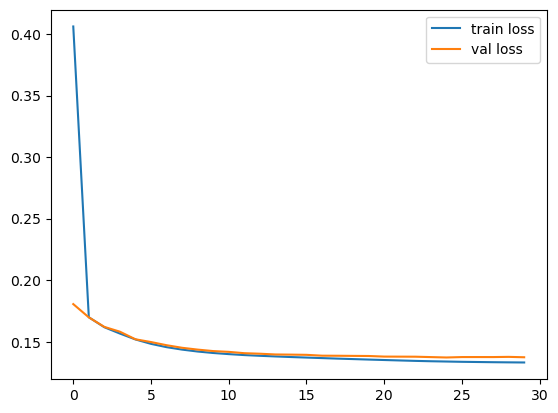

In [12]:
show_loss(train_losses, val_losses)

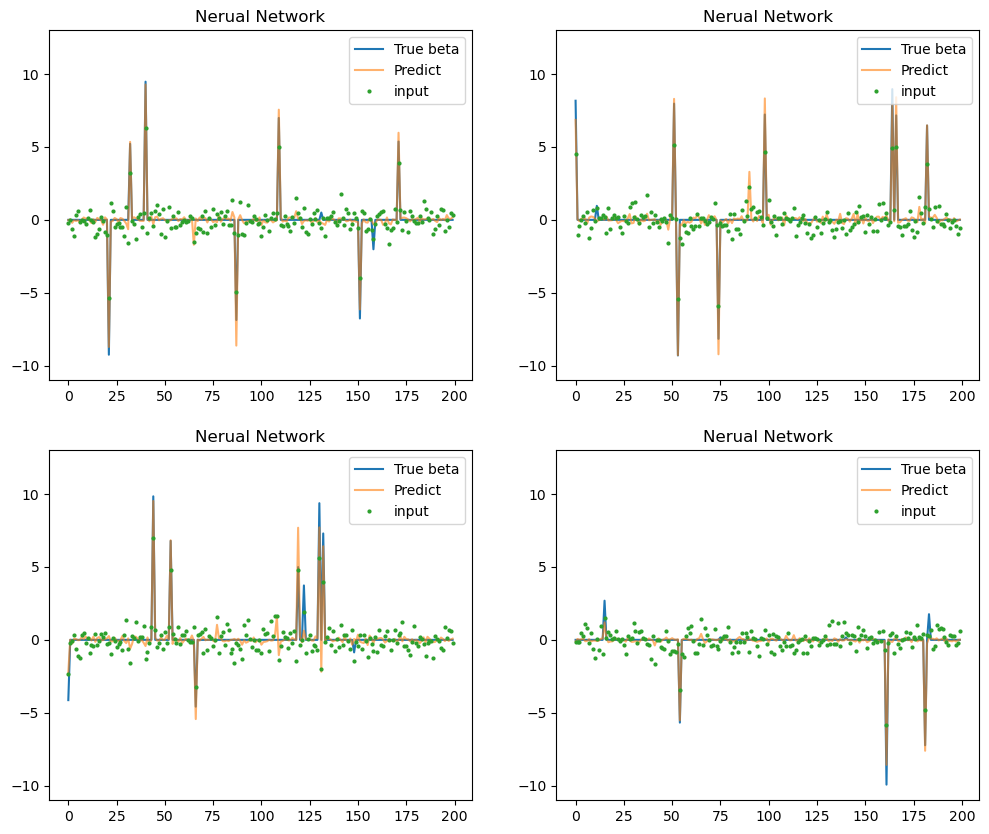

In [95]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(beta_test[i,])
    plt.plot(predict(md, Y_test[i,]), alpha=0.6)
    plt.plot(range(200), Y_test[i], 'o', ms=2)
    plt.legend(['True beta', 'Predict', 'input'], loc='upper right')
    plt.ylim(-11,13)
    plt.title("Nerual Network")
plt.show()

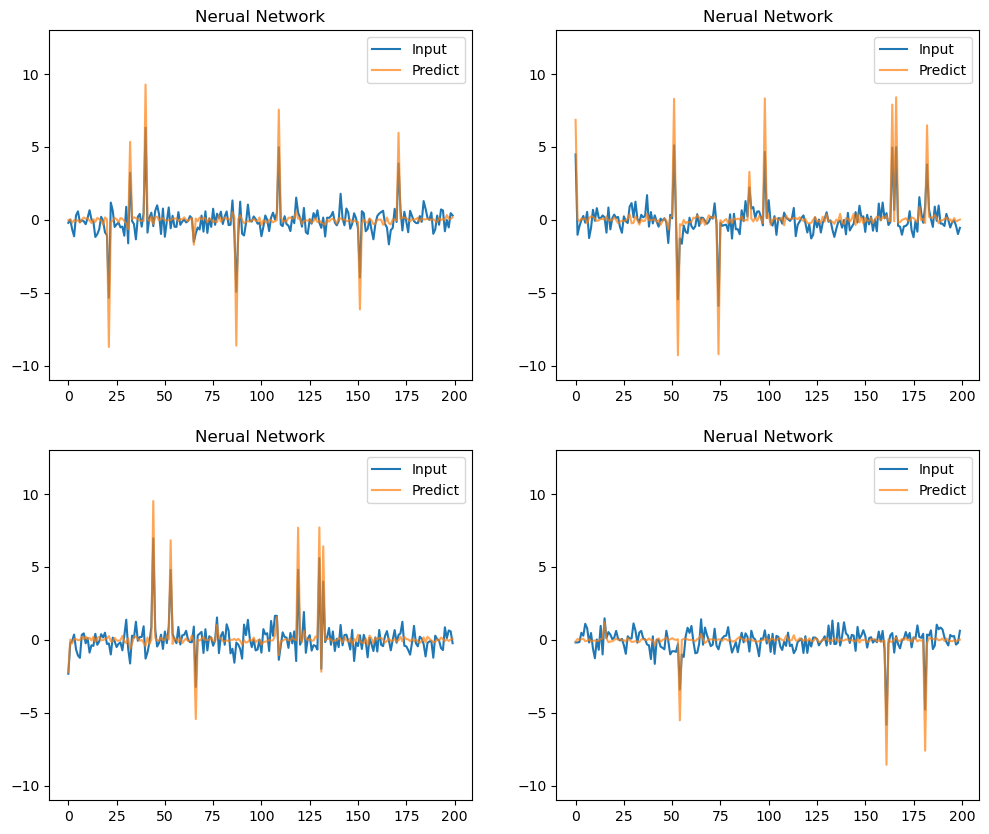

In [28]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(Y_test[i,])
    plt.plot(predict(md, Y_test[i,]), alpha=0.7)
    plt.legend(['Input', 'Predict'], loc='upper right')
    plt.ylim(-11,13)
    plt.title("Nerual Network")
plt.show()

In [16]:
torch.save(md.state_dict(), './model/md_I_mean.pt')

In [14]:
md_q025 = MLP(N=200, p=200).to(device)
train_losses, val_losses = train_model(md_q025, 0.001, 256, 100, Y_train, beta_train, loss_type='quantile', q=0.025, val_data=Y_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.03876
Val loss: 0.02326
Epoch: 2
Train loss: 0.02163
Val loss: 0.02063
Epoch: 3
Train loss: 0.01999
Val loss: 0.01969
Epoch: 4
Train loss: 0.01939
Val loss: 0.01916
Epoch: 5
Train loss: 0.01895
Val loss: 0.01894
Epoch: 6
Train loss: 0.01881
Val loss: 0.01889
Epoch: 7
Train loss: 0.01871
Val loss: 0.01881
Epoch: 8
Train loss: 0.01865
Val loss: 0.01862
Epoch: 9
Train loss: 0.01860
Val loss: 0.01861
Epoch: 10
Train loss: 0.01857
Val loss: 0.01865
Epoch: 11
Train loss: 0.01854
Val loss: 0.01861
Epoch: 12
Train loss: 0.01851
Val loss: 0.01856
Epoch: 13
Train loss: 0.01849
Val loss: 0.01849
Epoch: 14
Train loss: 0.01847
Val loss: 0.01853
Epoch: 15
Train loss: 0.01846
Val loss: 0.01851
Epoch: 16
Train loss: 0.01845
Val loss: 0.01848
Epoch: 17
Train loss: 0.01845
Val loss: 0.01861
Epoch: 18
Train loss: 0.01846
Val loss: 0.01848
Epoch: 19
Train loss: 0.01847
Val loss: 0.01858
Epoch: 20
Train loss: 0.01849
Val loss: 0.01859
Epoch: 21
Train loss: 0.01851
Val loss: 0.01857


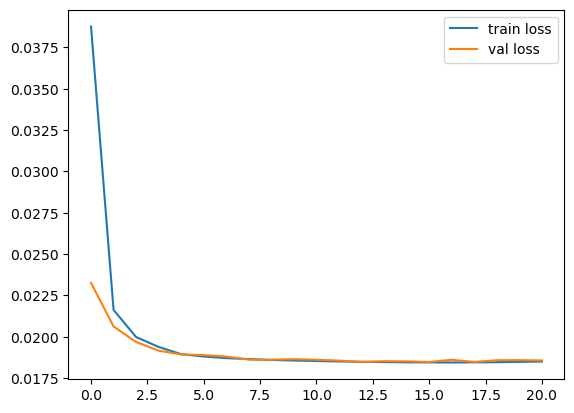

In [15]:
show_loss(train_losses, val_losses)

In [17]:
torch.save(md_q025.state_dict(), './model/md_I_q025.pt')

In [18]:
md_q975 = MLP(N=200, p=200).to(device)
train_losses, val_losses = train_model(md_q975, 0.001, 256, 100, Y_train, beta_train, loss_type='quantile', q=0.975, val_data=Y_val, val_labels=beta_val)

Epoch: 1
Train loss: 0.04068
Val loss: 0.02480
Epoch: 2
Train loss: 0.02283
Val loss: 0.02188
Epoch: 3
Train loss: 0.02118
Val loss: 0.02083
Epoch: 4
Train loss: 0.02031
Val loss: 0.01999
Epoch: 5
Train loss: 0.01969
Val loss: 0.01949
Epoch: 6
Train loss: 0.01930
Val loss: 0.01920
Epoch: 7
Train loss: 0.01908
Val loss: 0.01913
Epoch: 8
Train loss: 0.01897
Val loss: 0.01906
Epoch: 9
Train loss: 0.01891
Val loss: 0.01898
Epoch: 10
Train loss: 0.01886
Val loss: 0.01896
Epoch: 11
Train loss: 0.01881
Val loss: 0.01883
Epoch: 12
Train loss: 0.01878
Val loss: 0.01879
Epoch: 13
Train loss: 0.01876
Val loss: 0.01892
Epoch: 14
Train loss: 0.01873
Val loss: 0.01883
Epoch: 15
Train loss: 0.01872
Val loss: 0.01875
Epoch: 16
Train loss: 0.01870
Val loss: 0.01876
Epoch: 17
Train loss: 0.01869
Val loss: 0.01871
Epoch: 18
Train loss: 0.01868
Val loss: 0.01880
Epoch: 19
Train loss: 0.01868
Val loss: 0.01877
Epoch: 20
Train loss: 0.01868
Val loss: 0.01885
Epoch: 21
Train loss: 0.01867
Val loss: 0.01879
E

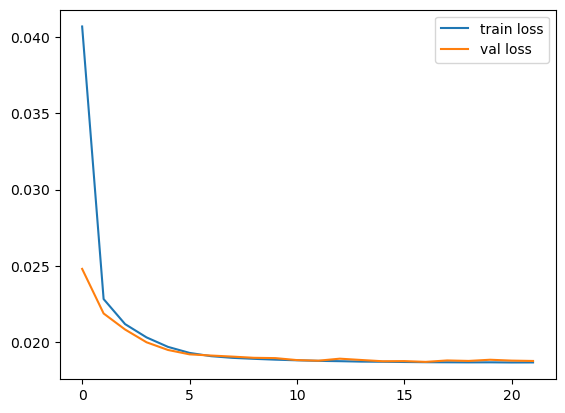

In [19]:
show_loss(train_losses, val_losses)

In [20]:
torch.save(md_q025.state_dict(), './model/md_I_q975.pt')

In [21]:
pred_q025 = predict(md_q025, Y_test)
pred_q975 = predict(md_q975, Y_test)

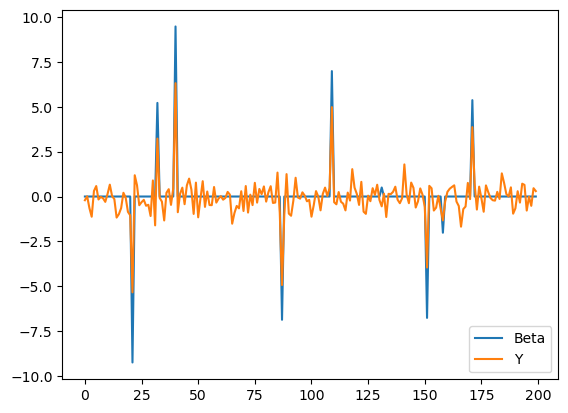

In [26]:
plt.plot(range(200), beta_test[0])
plt.plot(range(200), Y_test[0])
plt.legend(['Beta', 'Y'], loc='lower right')
plt.show()

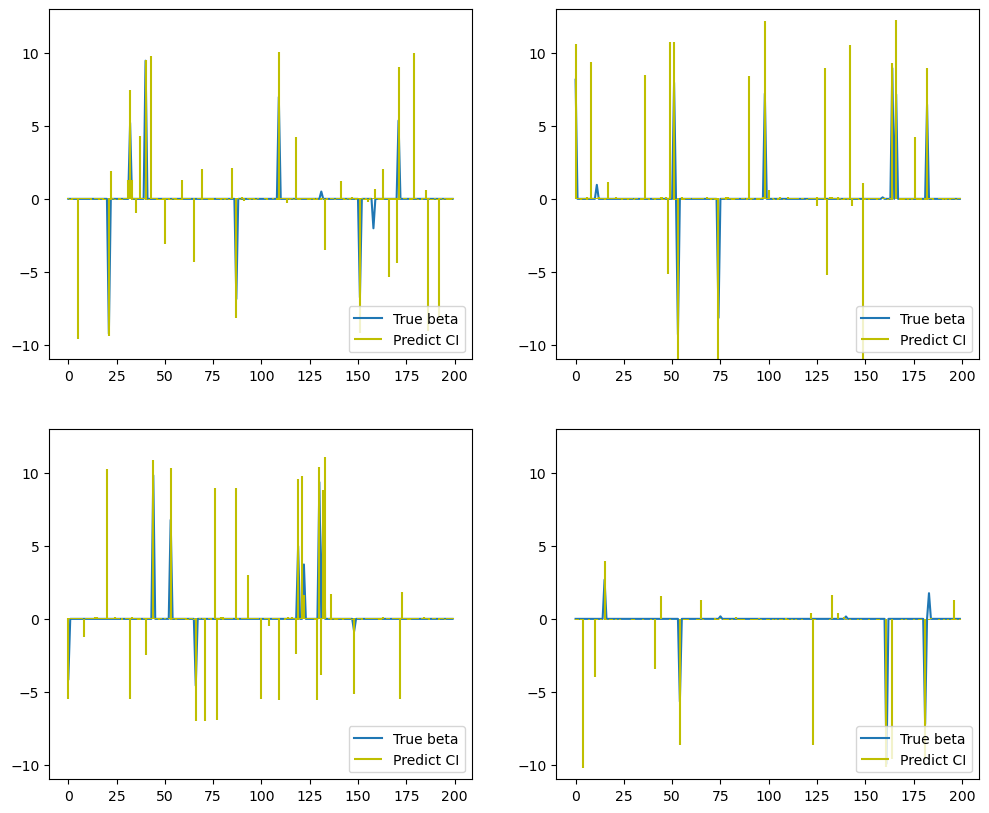

In [98]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(range(200), beta_test[i])
    # plt.plot(range(200), Y_test[i])
    plt.vlines(range(200), pred_q025[i], pred_q975[i], color='y')
    plt.ylim(-11,13)
    plt.legend(['True beta', 'Predict CI'], loc='lower right')
plt.show()

In [21]:
generator_ld = Generator_eye(p=10, theta=1, beta_range=(-10,10))

In [31]:
generator_ld_theta05 = Generator_eye(p=10, theta=0.5, beta_range=(-10,10))

In [32]:
generator_ld_theta005 = Generator_eye(p=10, theta=0.05, beta_range=(-10,10))

In [22]:
rng.seed(0)
gamma_ld_train, beta_ld_train, Y_ld_train = generator_ld.generate_samples(1000000)
gamma_ld_val, beta_ld_val, Y_ld_val = generator_ld.generate_samples(10000)
mean_ld = Y_ld_train.mean(0)
std_ld = Y_ld_train.std(0)
Y_ld_train = (Y_ld_train - mean_ld) / std_ld
Y_ld_val = (Y_ld_val - mean_ld) / std_ld

In [8]:
rng.seed(0)
gamma_ld_theta05_train, beta_ld_theta05_train, Y_ld_theta05_train = generator_ld_theta05.generate_samples(1000000)
gamma_ld_theta05_val, beta_ld_theta05_val, Y_ld_theta05_val = generator_ld_theta05.generate_samples(10000)
mean_ld_theta05 = Y_ld_theta05_train.mean(0)
std_ld_theta05 = Y_ld_theta05_train.std(0)
Y_ld_theta05_train = (Y_ld_theta05_train - mean_ld_theta05) / std_ld_theta05
Y_ld_theta05_val = (Y_ld_theta05_val - mean_ld_theta05) / std_ld_theta05

In [33]:
rng.seed(0)
gamma_ld_theta005_train, beta_ld_theta005_train, Y_ld_theta005_train = generator_ld_theta005.generate_samples(1000000)
gamma_ld_theta005_val, beta_ld_theta005_val, Y_ld_theta005_val = generator_ld_theta005.generate_samples(10000)
mean_ld_theta005 = Y_ld_theta005_train.mean(0)
std_ld_theta005 = Y_ld_theta005_train.std(0)
Y_ld_theta005_train = (Y_ld_theta005_train - mean_ld_theta005) / std_ld_theta005
Y_ld_theta005_val = (Y_ld_theta005_val - mean_ld_theta005) / std_ld_theta005

In [23]:
rng.seed(1)
gamma_ld_test, beta_ld_test, Y_ld_test = generator_ld.generate_samples(10000)
Y_ld_test = (Y_ld_test - mean_ld) / std_ld

In [9]:
rng.seed(1)
gamma_ld_theta05_test, beta_ld_theta05_test, Y_ld_theta05_test = generator_ld_theta05.generate_samples(10000)
Y_ld_theta05_test = (Y_ld_theta05_test - mean_ld_theta05) / std_ld_theta05

In [34]:
rng.seed(1)
gamma_ld_theta005_test, beta_ld_theta005_test, Y_ld_theta005_test = generator_ld_theta005.generate_samples(10000)
Y_ld_theta005_test = (Y_ld_theta005_test - mean_ld_theta005) / std_ld_theta005

In [10]:
class MLP_light(nn.Module):
    def __init__(self, N, p):
        super(MLP_light, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()
    
    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        output = self.fc3(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss
    
    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss

In [24]:
md_ld_mean = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_mean, 0.001, 256, 50, Y_ld_train, beta_ld_train, val_data=Y_ld_val, val_labels=beta_ld_val)

Epoch: 1
Train loss: 1.05083
Val loss: 0.97039
Epoch: 2
Train loss: 0.95822
Val loss: 0.94721
Epoch: 3
Train loss: 0.94177
Val loss: 0.93979
Epoch: 4
Train loss: 0.93795
Val loss: 0.93766
Epoch: 5
Train loss: 0.93639
Val loss: 0.93710
Epoch: 6
Train loss: 0.93518
Val loss: 0.93584
Epoch: 7
Train loss: 0.93406
Val loss: 0.93524
Epoch: 8
Train loss: 0.93311
Val loss: 0.93409
Epoch: 9
Train loss: 0.93223
Val loss: 0.93309
Epoch: 10
Train loss: 0.93127
Val loss: 0.93245
Epoch: 11
Train loss: 0.93044
Val loss: 0.93163
Epoch: 12
Train loss: 0.92973
Val loss: 0.93090
Epoch: 13
Train loss: 0.92903
Val loss: 0.93033
Epoch: 14
Train loss: 0.92839
Val loss: 0.92968
Epoch: 15
Train loss: 0.92784
Val loss: 0.92962
Epoch: 16
Train loss: 0.92734
Val loss: 0.92945
Epoch: 17
Train loss: 0.92683
Val loss: 0.92929
Epoch: 18
Train loss: 0.92635
Val loss: 0.92883
Epoch: 19
Train loss: 0.92587
Val loss: 0.92851
Epoch: 20
Train loss: 0.92545
Val loss: 0.92834
Epoch: 21
Train loss: 0.92507
Val loss: 0.92856
E

In [57]:
md_hd_subset_mean = MLP_light(200, 10).to(device)
train_losses, val_losses = train_model(md_hd_subset_mean, 0.001, 256, 50, Y_train, beta_train[:,:10], val_data=Y_val, val_labels=beta_val[:,:10])

Epoch: 1
Train loss: 0.17373
Val loss: 0.13246
Epoch: 2
Train loss: 0.11837
Val loss: 0.12655
Epoch: 3
Train loss: 0.11083
Val loss: 0.12649
Epoch: 4
Train loss: 0.10550
Val loss: 0.12715
Epoch: 5
Train loss: 0.10112
Val loss: 0.12833
Epoch: 6
Train loss: 0.09744
Val loss: 0.13000
Epoch: 7
Train loss: 0.09432
Val loss: 0.13253
Epoch: 8
Train loss: 0.09163
Val loss: 0.13388


In [12]:
md_ld_theta05_mean = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_theta05_mean, 0.001, 256, 50, Y_ld_theta05_train, beta_ld_theta05_train, val_data=Y_ld_theta05_val, val_labels=beta_ld_theta05_val)

Epoch: 1
Train loss: 0.80855
Val loss: 0.68140
Epoch: 2
Train loss: 0.67645
Val loss: 0.66500
Epoch: 3
Train loss: 0.66669
Val loss: 0.65998
Epoch: 4
Train loss: 0.66138
Val loss: 0.65588
Epoch: 5
Train loss: 0.65735
Val loss: 0.65339
Epoch: 6
Train loss: 0.65496
Val loss: 0.65219
Epoch: 7
Train loss: 0.65375
Val loss: 0.65184
Epoch: 8
Train loss: 0.65304
Val loss: 0.65135
Epoch: 9
Train loss: 0.65249
Val loss: 0.65090
Epoch: 10
Train loss: 0.65204
Val loss: 0.65038
Epoch: 11
Train loss: 0.65168
Val loss: 0.64997
Epoch: 12
Train loss: 0.65139
Val loss: 0.64929
Epoch: 13
Train loss: 0.65111
Val loss: 0.64933
Epoch: 14
Train loss: 0.65085
Val loss: 0.64894
Epoch: 15
Train loss: 0.65061
Val loss: 0.64886
Epoch: 16
Train loss: 0.65039
Val loss: 0.64879
Epoch: 17
Train loss: 0.65017
Val loss: 0.64848
Epoch: 18
Train loss: 0.64996
Val loss: 0.64815
Epoch: 19
Train loss: 0.64977
Val loss: 0.64776
Epoch: 20
Train loss: 0.64956
Val loss: 0.64730
Epoch: 21
Train loss: 0.64938
Val loss: 0.64709
E

In [35]:
md_ld_theta005_mean = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_theta005_mean, 0.001, 256, 50, Y_ld_theta005_train, beta_ld_theta005_train, val_data=Y_ld_theta005_val, val_labels=beta_ld_theta005_val)

Epoch: 1
Train loss: 0.13017
Val loss: 0.11762
Epoch: 2
Train loss: 0.11163
Val loss: 0.11430
Epoch: 3
Train loss: 0.10976
Val loss: 0.11283
Epoch: 4
Train loss: 0.10874
Val loss: 0.11233
Epoch: 5
Train loss: 0.10804
Val loss: 0.11186
Epoch: 6
Train loss: 0.10754
Val loss: 0.11148
Epoch: 7
Train loss: 0.10714
Val loss: 0.11110
Epoch: 8
Train loss: 0.10681
Val loss: 0.11078
Epoch: 9
Train loss: 0.10655
Val loss: 0.11051
Epoch: 10
Train loss: 0.10631
Val loss: 0.11005
Epoch: 11
Train loss: 0.10608
Val loss: 0.10974
Epoch: 12
Train loss: 0.10589
Val loss: 0.10961
Epoch: 13
Train loss: 0.10573
Val loss: 0.10943
Epoch: 14
Train loss: 0.10556
Val loss: 0.10931
Epoch: 15
Train loss: 0.10543
Val loss: 0.10911
Epoch: 16
Train loss: 0.10530
Val loss: 0.10907
Epoch: 17
Train loss: 0.10518
Val loss: 0.10903
Epoch: 18
Train loss: 0.10507
Val loss: 0.10881
Epoch: 19
Train loss: 0.10496
Val loss: 0.10879
Epoch: 20
Train loss: 0.10486
Val loss: 0.10875
Epoch: 21
Train loss: 0.10478
Val loss: 0.10863
E

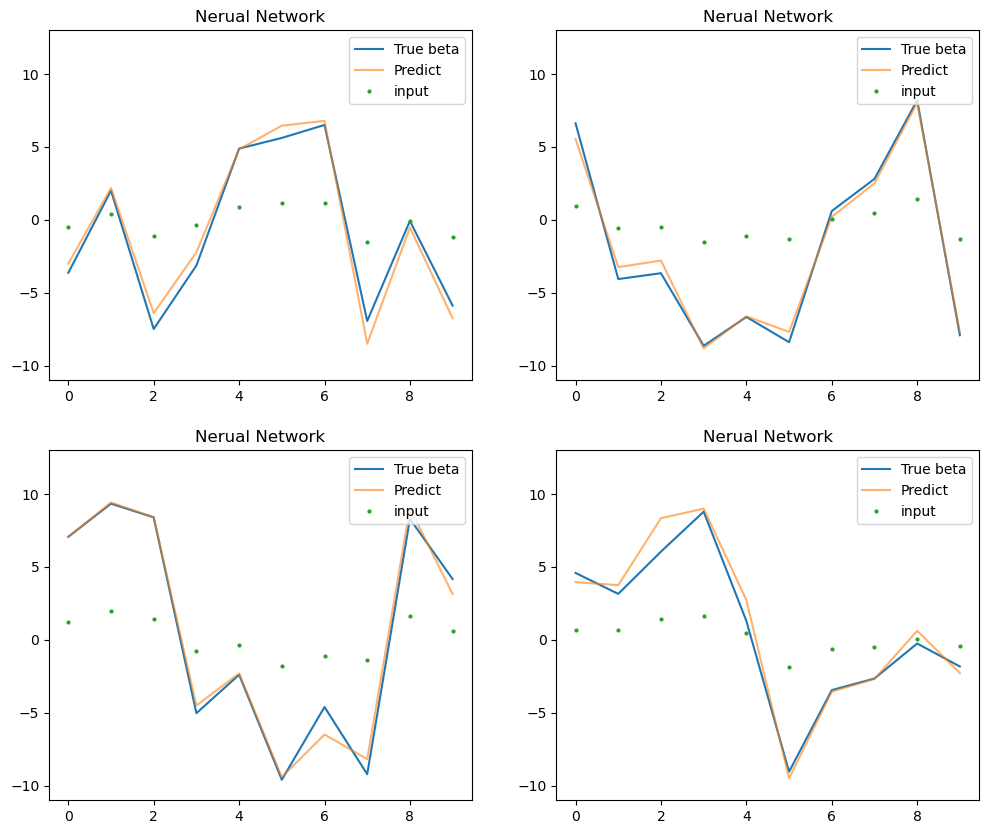

In [111]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(beta_ld_test[i,])
    plt.plot(predict(md_ld_mean, Y_ld_test[i,]), alpha=0.6)
    plt.plot(range(10), Y_ld_test[i], 'o', ms=2)
    plt.legend(['True beta', 'Predict', 'input'], loc='upper right')
    plt.ylim(-11,13)
    plt.title("Nerual Network")
plt.show()

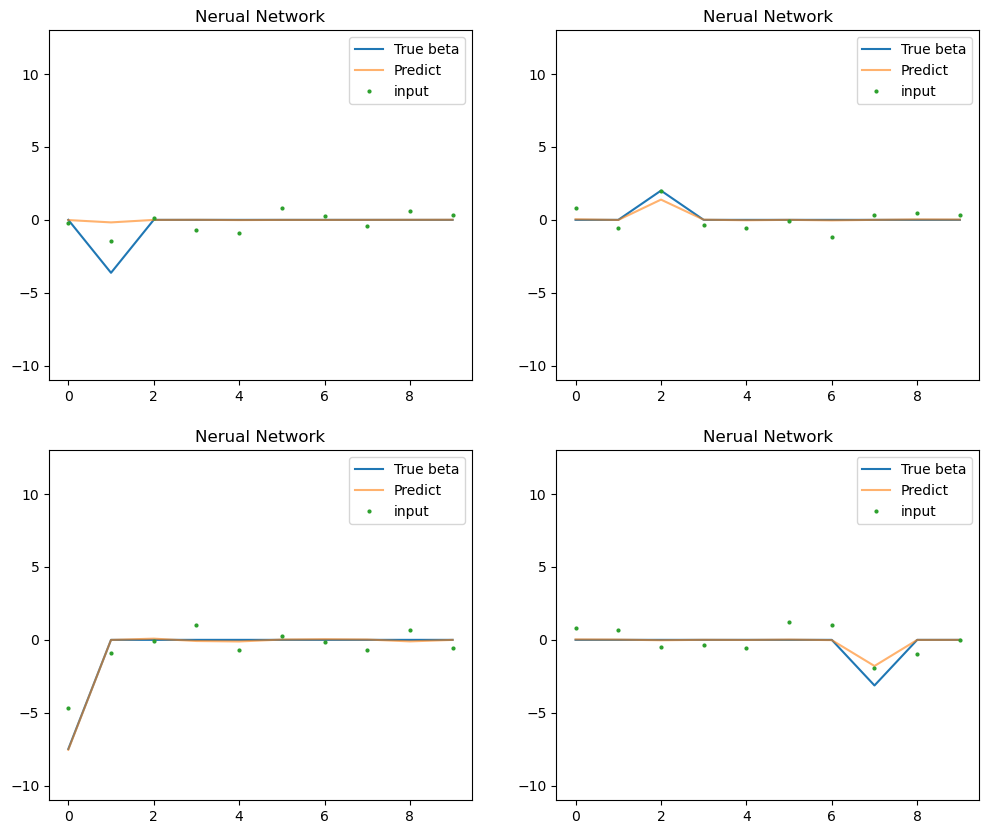

In [40]:
subset = [2,3,4,8]
plt.figure(figsize=(12,10))
for i, idx in enumerate(subset):
    plt.subplot(2, 2, i+1)
    plt.plot(beta_ld_theta005_test[idx,])
    plt.plot(predict(md_ld_theta005_mean, Y_ld_theta005_test[idx,]), alpha=0.6)
    plt.plot(range(10), Y_ld_theta005_test[idx], 'o', ms=2)
    plt.legend(['True beta', 'Predict', 'input'], loc='upper right')
    plt.ylim(-11,13)
    plt.title("Nerual Network")
plt.show()

In [59]:
np.where(np.abs(beta_test[:,:10])>5)

(array([   1,    6,    7, ..., 9987, 9989, 9993], dtype=int64),
 array([0, 7, 5, ..., 0, 5, 1], dtype=int64))

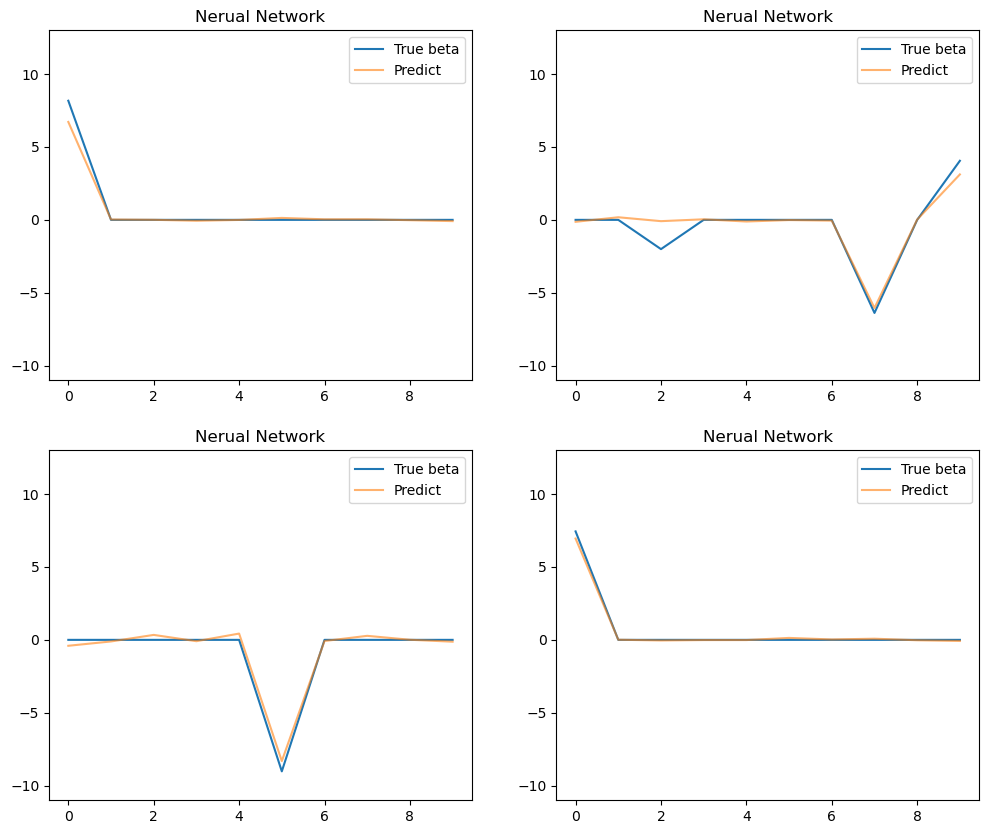

In [60]:
subset = [1,6,7,9987]
plt.figure(figsize=(12,10))
for i, idx in enumerate(subset):
    plt.subplot(2, 2, i+1)
    plt.plot(beta_test[idx,:10])
    plt.plot(predict(md_hd_subset_mean, Y_test[idx,]), alpha=0.6)
    # plt.plot(range(10), Y_test[idx], 'o', ms=2)
    plt.legend(['True beta', 'Predict'], loc='upper right')
    plt.ylim(-11,13)
    plt.title("Nerual Network")
plt.show()

In [25]:
md_ld_q025 = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_q025, 0.001, 256, 50, Y_ld_train, beta_ld_train, loss_type='quantile', q=0.025, val_data=Y_ld_val, val_labels=beta_ld_val)

Epoch: 1
Train loss: 0.06667
Val loss: 0.05936
Epoch: 2
Train loss: 0.05933
Val loss: 0.05784
Epoch: 3
Train loss: 0.05772
Val loss: 0.05804
Epoch: 4
Train loss: 0.05684
Val loss: 0.05667
Epoch: 5
Train loss: 0.05651
Val loss: 0.05682
Epoch: 6
Train loss: 0.05631
Val loss: 0.05663
Epoch: 7
Train loss: 0.05621
Val loss: 0.05664
Epoch: 8
Train loss: 0.05612
Val loss: 0.05651
Epoch: 9
Train loss: 0.05606
Val loss: 0.05634
Epoch: 10
Train loss: 0.05601
Val loss: 0.05595
Epoch: 11
Train loss: 0.05596
Val loss: 0.05606
Epoch: 12
Train loss: 0.05591
Val loss: 0.05589
Epoch: 13
Train loss: 0.05586
Val loss: 0.05591
Epoch: 14
Train loss: 0.05582
Val loss: 0.05590
Epoch: 15
Train loss: 0.05581
Val loss: 0.05582
Epoch: 16
Train loss: 0.05576
Val loss: 0.05599
Epoch: 17
Train loss: 0.05574
Val loss: 0.05569
Epoch: 18
Train loss: 0.05572
Val loss: 0.05565
Epoch: 19
Train loss: 0.05571
Val loss: 0.05574
Epoch: 20
Train loss: 0.05570
Val loss: 0.05559
Epoch: 21
Train loss: 0.05567
Val loss: 0.05567
E

In [14]:
md_ld_theta05_q025 = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_theta05_q025, 0.001, 256, 50, Y_ld_theta05_train, beta_ld_theta05_train, loss_type='quantile', q=0.025, val_data=Y_ld_theta05_val, val_labels=beta_ld_theta05_val)

Epoch: 1
Train loss: 0.05666
Val loss: 0.04963
Epoch: 2
Train loss: 0.04889
Val loss: 0.04863
Epoch: 3
Train loss: 0.04802
Val loss: 0.04780
Epoch: 4
Train loss: 0.04756
Val loss: 0.04758
Epoch: 5
Train loss: 0.04721
Val loss: 0.04724
Epoch: 6
Train loss: 0.04696
Val loss: 0.04702
Epoch: 7
Train loss: 0.04681
Val loss: 0.04691
Epoch: 8
Train loss: 0.04673
Val loss: 0.04696
Epoch: 9
Train loss: 0.04666
Val loss: 0.04692
Epoch: 10
Train loss: 0.04661
Val loss: 0.04688
Epoch: 11
Train loss: 0.04657
Val loss: 0.04672
Epoch: 12
Train loss: 0.04653
Val loss: 0.04672
Epoch: 13
Train loss: 0.04651
Val loss: 0.04679
Epoch: 14
Train loss: 0.04647
Val loss: 0.04674
Epoch: 15
Train loss: 0.04644
Val loss: 0.04687
Epoch: 16
Train loss: 0.04643
Val loss: 0.04668
Epoch: 17
Train loss: 0.04641
Val loss: 0.04669
Epoch: 18
Train loss: 0.04638
Val loss: 0.04678
Epoch: 19
Train loss: 0.04636
Val loss: 0.04660
Epoch: 20
Train loss: 0.04634
Val loss: 0.04658
Epoch: 21
Train loss: 0.04633
Val loss: 0.04664
E

In [41]:
md_ld_theta005_q025 = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_theta005_q025, 0.001, 256, 50, Y_ld_theta005_train, beta_ld_theta005_train, loss_type='quantile', q=0.025, val_data=Y_ld_theta005_val, val_labels=beta_ld_theta005_val)

Epoch: 1
Train loss: 0.01457
Val loss: 0.01291
Epoch: 2
Train loss: 0.01206
Val loss: 0.01237
Epoch: 3
Train loss: 0.01176
Val loss: 0.01218
Epoch: 4
Train loss: 0.01161
Val loss: 0.01217
Epoch: 5
Train loss: 0.01150
Val loss: 0.01189
Epoch: 6
Train loss: 0.01142
Val loss: 0.01198
Epoch: 7
Train loss: 0.01134
Val loss: 0.01182
Epoch: 8
Train loss: 0.01130
Val loss: 0.01196
Epoch: 9
Train loss: 0.01125
Val loss: 0.01178
Epoch: 10
Train loss: 0.01122
Val loss: 0.01179
Epoch: 11
Train loss: 0.01118
Val loss: 0.01182
Epoch: 12
Train loss: 0.01116
Val loss: 0.01172
Epoch: 13
Train loss: 0.01113
Val loss: 0.01171
Epoch: 14
Train loss: 0.01111
Val loss: 0.01180
Epoch: 15
Train loss: 0.01109
Val loss: 0.01161
Epoch: 16
Train loss: 0.01109
Val loss: 0.01173
Epoch: 17
Train loss: 0.01107
Val loss: 0.01176
Epoch: 18
Train loss: 0.01106
Val loss: 0.01174
Epoch: 19
Train loss: 0.01105
Val loss: 0.01168
Epoch: 20
Train loss: 0.01104
Val loss: 0.01167


In [61]:
md_hd_subset_q025 = MLP_light(200, 10).to(device)
train_losses, val_losses = train_model(md_hd_subset_q025, 0.001, 256, 50, Y_train, beta_train[:,:10], loss_type='quantile', q=0.025, val_data=Y_val, val_labels=beta_val[:,:10])

Epoch: 1
Train loss: 0.01807
Val loss: 0.01439
Epoch: 2
Train loss: 0.01384
Val loss: 0.01422
Epoch: 3
Train loss: 0.01302
Val loss: 0.01440
Epoch: 4
Train loss: 0.01248
Val loss: 0.01424
Epoch: 5
Train loss: 0.01200
Val loss: 0.01427
Epoch: 6
Train loss: 0.01165
Val loss: 0.01458
Epoch: 7
Train loss: 0.01136
Val loss: 0.01453


In [26]:
md_ld_q975 = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_q975, 0.001, 256, 50, Y_ld_train, beta_ld_train, loss_type='quantile', q=0.975, val_data=Y_ld_val, val_labels=beta_ld_val)

Epoch: 1
Train loss: 0.06651
Val loss: 0.06188
Epoch: 2
Train loss: 0.05917
Val loss: 0.05829
Epoch: 3
Train loss: 0.05750
Val loss: 0.05733
Epoch: 4
Train loss: 0.05677
Val loss: 0.05742
Epoch: 5
Train loss: 0.05645
Val loss: 0.05720
Epoch: 6
Train loss: 0.05630
Val loss: 0.05713
Epoch: 7
Train loss: 0.05619
Val loss: 0.05686
Epoch: 8
Train loss: 0.05613
Val loss: 0.05692
Epoch: 9
Train loss: 0.05606
Val loss: 0.05679
Epoch: 10
Train loss: 0.05602
Val loss: 0.05665
Epoch: 11
Train loss: 0.05597
Val loss: 0.05690
Epoch: 12
Train loss: 0.05594
Val loss: 0.05658
Epoch: 13
Train loss: 0.05589
Val loss: 0.05673
Epoch: 14
Train loss: 0.05586
Val loss: 0.05650
Epoch: 15
Train loss: 0.05583
Val loss: 0.05627
Epoch: 16
Train loss: 0.05578
Val loss: 0.05640
Epoch: 17
Train loss: 0.05574
Val loss: 0.05612
Epoch: 18
Train loss: 0.05573
Val loss: 0.05621
Epoch: 19
Train loss: 0.05571
Val loss: 0.05626
Epoch: 20
Train loss: 0.05569
Val loss: 0.05605
Epoch: 21
Train loss: 0.05566
Val loss: 0.05612
E

In [16]:
md_ld_theta05_q975 = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_theta05_q975, 0.001, 256, 50, Y_ld_theta05_train, beta_ld_theta05_train, loss_type='quantile', q=0.975, val_data=Y_ld_theta05_val, val_labels=beta_ld_theta05_val)

Epoch: 1
Train loss: 0.05683
Val loss: 0.04978
Epoch: 2
Train loss: 0.04894
Val loss: 0.04815
Epoch: 3
Train loss: 0.04799
Val loss: 0.04756
Epoch: 4
Train loss: 0.04755
Val loss: 0.04710
Epoch: 5
Train loss: 0.04723
Val loss: 0.04693
Epoch: 6
Train loss: 0.04699
Val loss: 0.04685
Epoch: 7
Train loss: 0.04684
Val loss: 0.04673
Epoch: 8
Train loss: 0.04675
Val loss: 0.04669
Epoch: 9
Train loss: 0.04668
Val loss: 0.04669
Epoch: 10
Train loss: 0.04663
Val loss: 0.04657
Epoch: 11
Train loss: 0.04659
Val loss: 0.04658
Epoch: 12
Train loss: 0.04655
Val loss: 0.04658
Epoch: 13
Train loss: 0.04651
Val loss: 0.04642
Epoch: 14
Train loss: 0.04647
Val loss: 0.04661
Epoch: 15
Train loss: 0.04645
Val loss: 0.04639
Epoch: 16
Train loss: 0.04642
Val loss: 0.04646
Epoch: 17
Train loss: 0.04640
Val loss: 0.04645
Epoch: 18
Train loss: 0.04638
Val loss: 0.04639
Epoch: 19
Train loss: 0.04636
Val loss: 0.04649
Epoch: 20
Train loss: 0.04635
Val loss: 0.04642
Epoch: 21
Train loss: 0.04633
Val loss: 0.04644
E

In [42]:
md_ld_theta005_q975 = MLP_light(10, 10).to(device)
train_losses, val_losses = train_model(md_ld_theta005_q975, 0.001, 256, 50, Y_ld_theta005_train, beta_ld_theta005_train, loss_type='quantile', q=0.975, val_data=Y_ld_theta005_val, val_labels=beta_ld_theta005_val)

Epoch: 1
Train loss: 0.01454
Val loss: 0.01244
Epoch: 2
Train loss: 0.01180
Val loss: 0.01199
Epoch: 3
Train loss: 0.01148
Val loss: 0.01184
Epoch: 4
Train loss: 0.01132
Val loss: 0.01172
Epoch: 5
Train loss: 0.01120
Val loss: 0.01169
Epoch: 6
Train loss: 0.01110
Val loss: 0.01158
Epoch: 7
Train loss: 0.01102
Val loss: 0.01154
Epoch: 8
Train loss: 0.01096
Val loss: 0.01139
Epoch: 9
Train loss: 0.01092
Val loss: 0.01147
Epoch: 10
Train loss: 0.01089
Val loss: 0.01139
Epoch: 11
Train loss: 0.01085
Val loss: 0.01133
Epoch: 12
Train loss: 0.01083
Val loss: 0.01136
Epoch: 13
Train loss: 0.01080
Val loss: 0.01131
Epoch: 14
Train loss: 0.01079
Val loss: 0.01131
Epoch: 15
Train loss: 0.01077
Val loss: 0.01129
Epoch: 16
Train loss: 0.01075
Val loss: 0.01124
Epoch: 17
Train loss: 0.01074
Val loss: 0.01134
Epoch: 18
Train loss: 0.01073
Val loss: 0.01126
Epoch: 19
Train loss: 0.01072
Val loss: 0.01118
Epoch: 20
Train loss: 0.01071
Val loss: 0.01132
Epoch: 21
Train loss: 0.01071
Val loss: 0.01130
E

In [62]:
md_hd_subset_q975 = MLP_light(200, 10).to(device)
train_losses, val_losses = train_model(md_hd_subset_q975, 0.001, 256, 50, Y_train, beta_train[:,:10], loss_type='quantile', q=0.975, val_data=Y_val, val_labels=beta_val[:,:10])

Epoch: 1
Train loss: 0.01804
Val loss: 0.01504
Epoch: 2
Train loss: 0.01387
Val loss: 0.01445
Epoch: 3
Train loss: 0.01304
Val loss: 0.01445
Epoch: 4
Train loss: 0.01246
Val loss: 0.01436
Epoch: 5
Train loss: 0.01203
Val loss: 0.01446
Epoch: 6
Train loss: 0.01170
Val loss: 0.01436
Epoch: 7
Train loss: 0.01136
Val loss: 0.01434
Epoch: 8
Train loss: 0.01111
Val loss: 0.01439
Epoch: 9
Train loss: 0.01093
Val loss: 0.01436
Epoch: 10
Train loss: 0.01076
Val loss: 0.01445
Epoch: 11
Train loss: 0.01061
Val loss: 0.01466
Epoch: 12
Train loss: 0.01051
Val loss: 0.01483


In [27]:
pred_ld_q025 = predict(md_ld_q025, Y_ld_test)
pred_ld_q975 = predict(md_ld_q975, Y_ld_test)

In [17]:
pred_ld_theta05_q025 = predict(md_ld_theta05_q025, Y_ld_theta05_test)
pred_ld_theta05_q975 = predict(md_ld_theta05_q975, Y_ld_theta05_test)

In [43]:
pred_ld_theta005_q025 = predict(md_ld_theta005_q025, Y_ld_theta005_test)
pred_ld_theta005_q975 = predict(md_ld_theta005_q975, Y_ld_theta005_test)

In [63]:
pred_hd_subset_q025 = predict(md_hd_subset_q025, Y_test)
pred_hd_subset_q975 = predict(md_hd_subset_q975, Y_test)

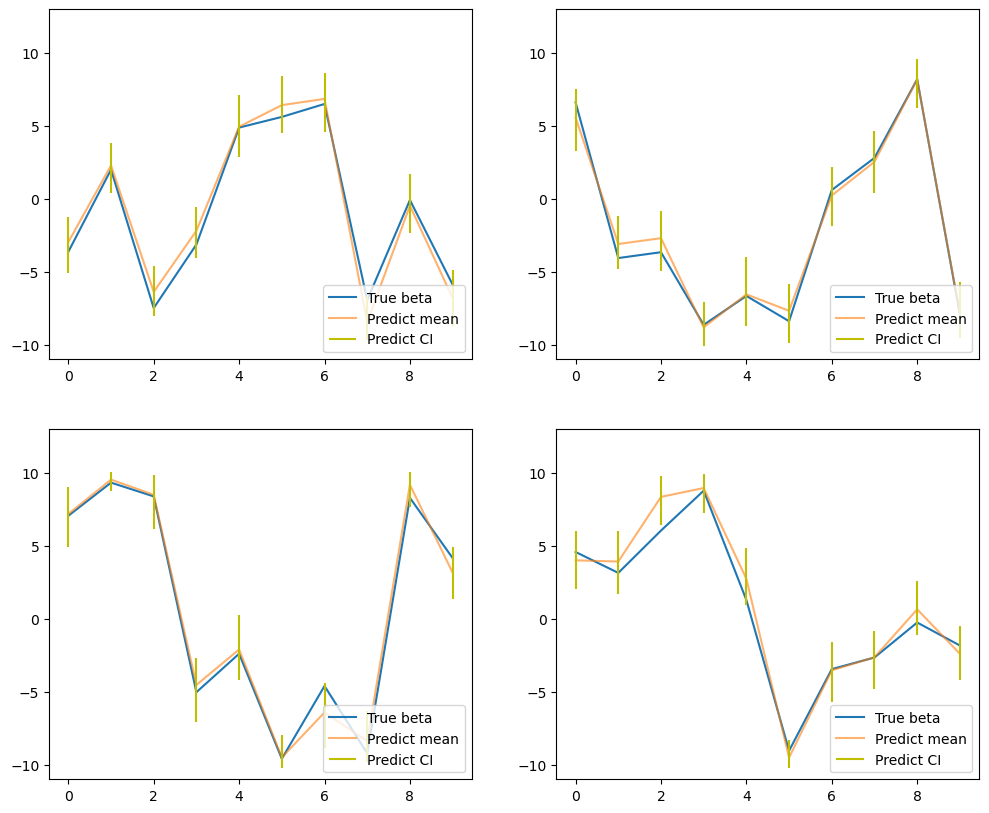

In [29]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(range(10), beta_ld_test[i])
    plt.plot(predict(md_ld_mean, Y_ld_test[i,]), alpha=0.6)
    plt.vlines(range(10), pred_ld_q025[i], pred_ld_q975[i], color='y')
    plt.ylim(-11,13)
    plt.legend(['True beta', 'Predict mean', 'Predict CI'], loc='lower right')
plt.show()

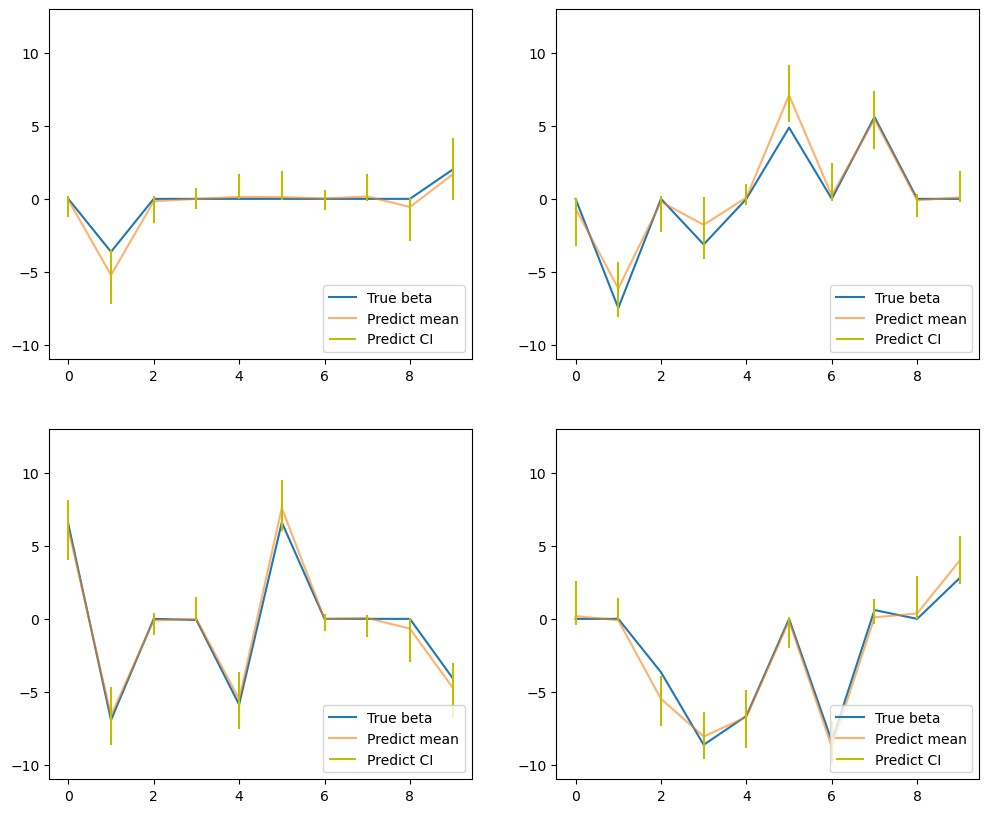

In [19]:
plt.figure(figsize=(12,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(range(10), beta_ld_theta05_test[i])
    plt.plot(predict(md_ld_theta05_mean, Y_ld_theta05_test[i,]), alpha=0.6)
    plt.vlines(range(10), pred_ld_theta05_q025[i], pred_ld_theta05_q975[i], color='y')
    plt.ylim(-11,13)
    plt.legend(['True beta', 'Predict mean', 'Predict CI'], loc='lower right')
plt.show()

In [45]:
np.where(np.abs(beta_ld_theta005_test)>5)

(array([   4,   13,   15, ..., 9995, 9996, 9999], dtype=int64),
 array([0, 1, 1, ..., 1, 7, 2], dtype=int64))

In [48]:
np.where((np.abs(beta_ld_theta005_test)<4)&(np.abs(beta_ld_theta005_test)>3))

(array([   2,    8,   25,   74,   86,   96,  170,  196,  240,  243,  272,
         299,  300,  313,  316,  334,  369,  381,  404,  419,  425,  430,
         435,  474,  482,  489,  499,  523,  547,  566,  574,  578,  581,
         601,  605,  605,  637,  670,  729,  732,  774,  797,  813,  817,
         827,  828,  830,  835,  870,  873,  884,  886,  891,  903,  908,
         920,  938,  944,  968,  979,  980, 1045, 1046, 1076, 1084, 1118,
        1226, 1229, 1245, 1261, 1263, 1297, 1308, 1316, 1326, 1382, 1382,
        1404, 1436, 1453, 1461, 1504, 1516, 1516, 1522, 1532, 1532, 1548,
        1596, 1601, 1638, 1643, 1665, 1678, 1684, 1706, 1810, 1810, 1826,
        1842, 1913, 1926, 1929, 1945, 1945, 1949, 1952, 2016, 2061, 2063,
        2074, 2075, 2112, 2113, 2128, 2198, 2211, 2212, 2256, 2266, 2298,
        2330, 2342, 2367, 2370, 2379, 2398, 2407, 2452, 2466, 2477, 2526,
        2529, 2550, 2590, 2603, 2621, 2622, 2628, 2673, 2722, 2762, 2788,
        2790, 2791, 2846, 2869, 2881, 

In [51]:
beta_ld_theta005_test[2]

array([ 0.        , -3.63077559,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

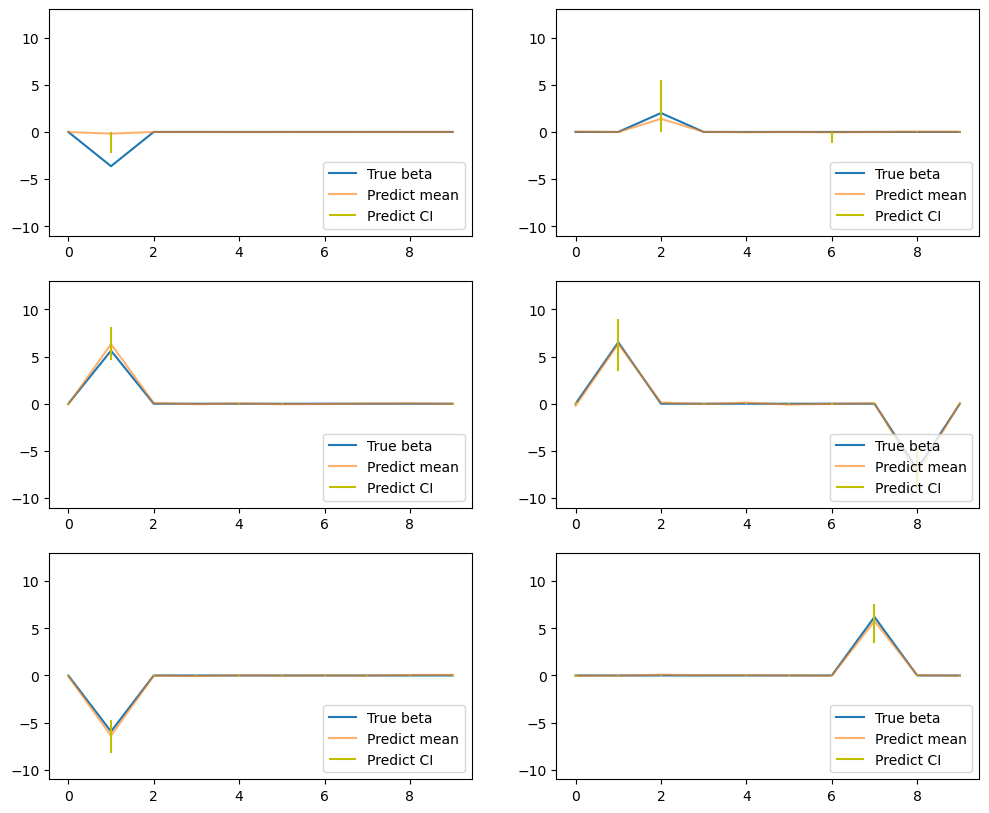

In [46]:
subset = [2,3,13,15,9995,9996]
plt.figure(figsize=(12,10))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(10), beta_ld_theta005_test[idx])
    plt.plot(predict(md_ld_theta005_mean, Y_ld_theta005_test[idx,]), alpha=0.6)
    plt.vlines(range(10), pred_ld_theta005_q025[idx], pred_ld_theta005_q975[idx], color='y')
    plt.ylim(-11,13)
    plt.legend(['True beta', 'Predict mean', 'Predict CI'], loc='lower right')
plt.show()

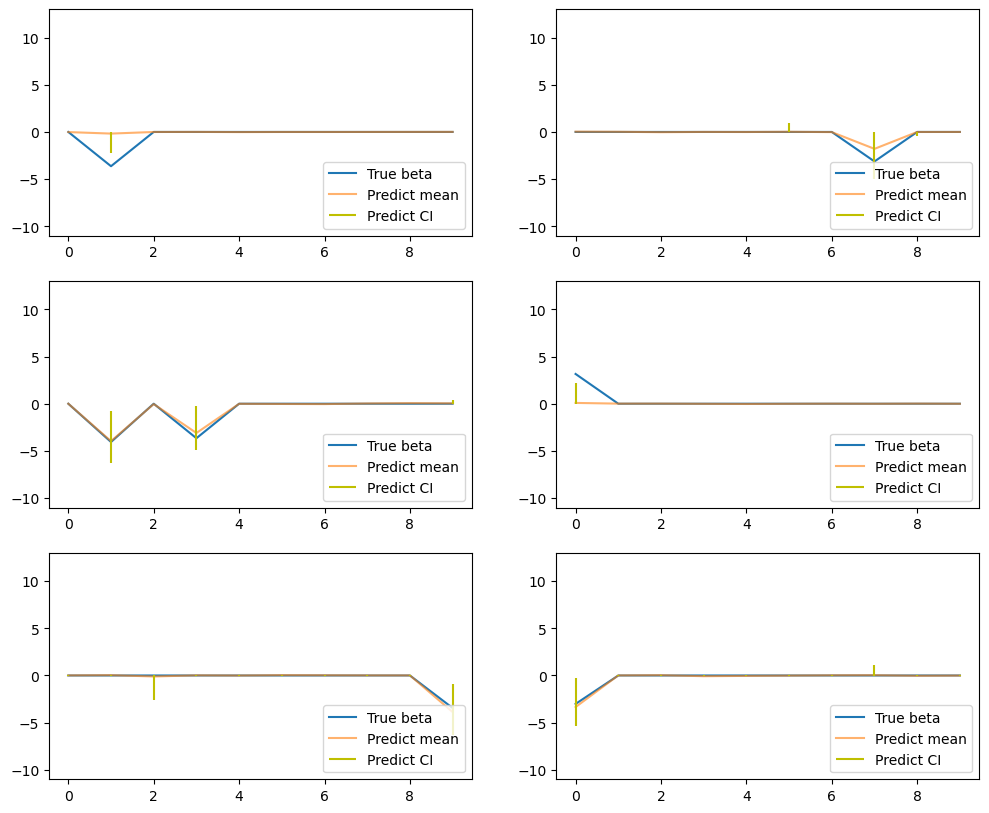

In [49]:
subset = [2,8,25,74,86,96]
plt.figure(figsize=(12,10))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(10), beta_ld_theta005_test[idx])
    plt.plot(predict(md_ld_theta005_mean, Y_ld_theta005_test[idx,]), alpha=0.6)
    plt.vlines(range(10), pred_ld_theta005_q025[idx], pred_ld_theta005_q975[idx], color='y')
    plt.ylim(-11,13)
    plt.legend(['True beta', 'Predict mean', 'Predict CI'], loc='lower right')
plt.show()

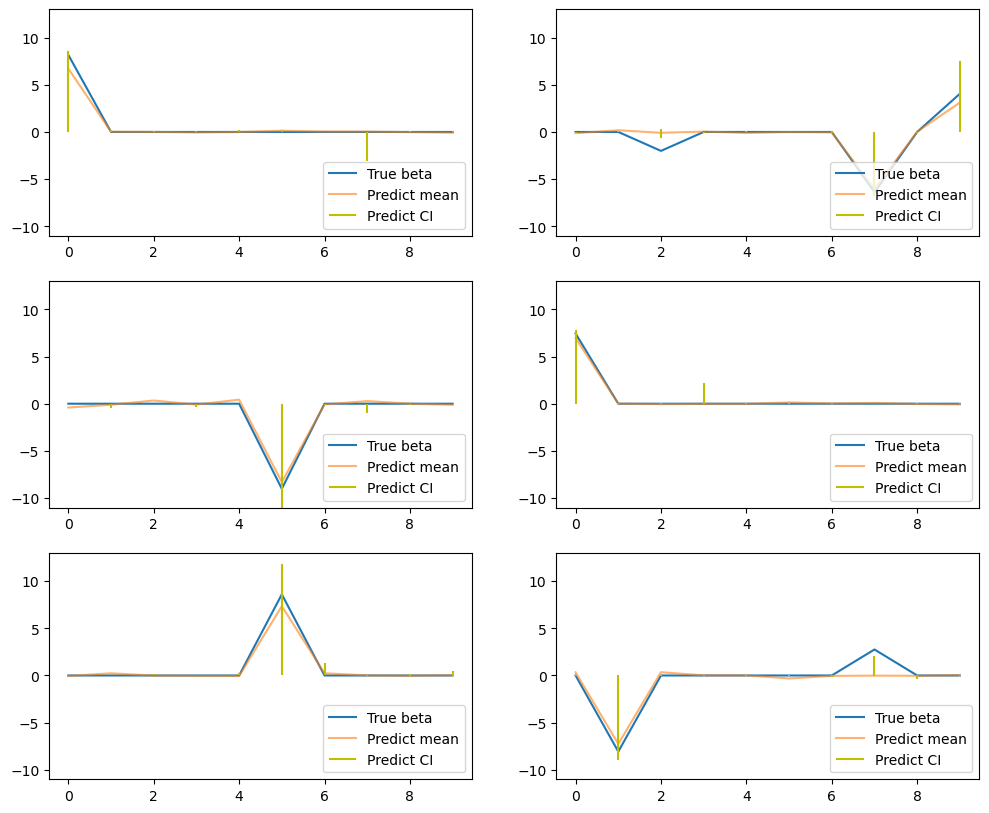

In [64]:
subset = [1,6,7,9987,9989,9993]
plt.figure(figsize=(12,10))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(10), beta_test[idx,:10])
    plt.plot(predict(md_hd_subset_mean, Y_test[idx,]), alpha=0.6)
    plt.vlines(range(10), pred_hd_subset_q025[idx], pred_hd_subset_q975[idx], color='y')
    plt.ylim(-11,13)
    plt.legend(['True beta', 'Predict mean', 'Predict CI'], loc='lower right')
plt.show()

In [9]:
def compute_p(beta, y, theta, sigma):
    return theta * np.exp(-(y-beta)**2 / (2 * sigma**2)) + (1-theta) * np.exp(-y**2 / (2 * sigma**2))

In [10]:
beta = np.linspace(-3, 3, 10000)

In [11]:
p = compute_p(beta, 2, 0.05, 1)

In [12]:
0.0006 * np.sum(p[:9999]) / compute_c(2, 0.05, 1)

0.9998896233895808

In [66]:
rng.rand(3,2)

array([[0.51279774, 0.62133786],
       [0.0377208 , 0.0794336 ],
       [0.48984867, 0.19415153]])